In [220]:
import numpy as np
from lattice import lattice_2D
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
from LLGS_simulation import LLGS_Simulation_2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import glob
from numba import njit, prange

In [221]:
problem_name = "NiPS3_rotation"
Hexagonal_monolayer = lattice_2D(2,4,4)
Hexagonal_monolayer.set_position(
    r_a = np.array([1,0]),
    r_b = np.array([0.5,0.5*np.sqrt(3)]),
    r_site = np.array((
    [0.5,np.sqrt(3)/6] #first site
    ,[1,np.sqrt(3)/3] #second site
    ))
)

In [222]:
def initial_AFM_ZigZagChain(lattice:lattice_2D):
    """
        Initial particles
    """
    N=lattice.N
    sx=np.zeros(N)
    sy=np.zeros(N)
    for n in range(N):
        if lattice._tag[n,2]%2==0:
            sx[n]=1
        else:
            sx[n]=-1
    sy=np.random.normal(0,0.1,N)
    sz=np.zeros(N)
    spins = np.transpose(np.vstack((sx,sy,sz)))
    spins_normalized = normalize(spins)

    lattice.set_spins(spins_normalized)
    return lattice

In [223]:
initial_AFM_ZigZagChain(Hexagonal_monolayer)

In [224]:
tags = Hexagonal_monolayer._tag.astype(np.int32)

def H_E_NiPS3_fully_conected(tags,J_1=0,J_2=0,J_3=0):
    N = len(tags[:,0])
    H_E = np.zeros((N,N))

    site = tags[:,0]
    a = tags[:,1]
    b = tags[:,2]

    def is_neighbor(i,j):
        if site[i] != site[j]:
            if a[j] == a[i] and b[j] == b[i]:
                return True
            elif a[j] == a[i]+site[i]-site[j] and b[j] == b[i]:
                return True
            elif a[j] == a[i] and b[j] == b[i]+site[i]-site[j]:
                return True
            else:
                return False        
        else:
            return False
    
    def is_next_nearest_neighbor(i,j):
        if site[i] == site[j]:
            if a[j] == a[i]+1 and b[j] == b[i]:
                return True
            elif a[j] == a[i]-1 and b[j] == b[i]:
                return True
            elif a[j] == a[i] and b[j] == b[i]+1:
                return True
            elif a[j] == a[i] and b[j] == b[i]-1:
                return True
            elif a[j] == a[i]-1 and b[j] == b[i]+1:
                return True
            elif a[j] == a[i]+1 and b[j] == b[i]-1:
                return True
            else:
                return False        
        else:
            return False

    def is_next_next_nearest_neighbor(i,j):
        if site[i] != site[j]:
            if a[j] == a[i]-1 and b[j] == b[i]+1:
                return True
            elif a[j] == a[i]+1 and b[j] == b[i]-1:
                return True
            elif a[j] == a[i]+site[i]-site[j] and b[j] == b[i]+site[i]-site[j]:
                return True
            else:
                return False        
        else:
            return False

    def update_H_E():
        for i in range(N):
            for j in range(N):
                if is_neighbor(i,j) == True:
                    H_E[i,j] = J_1
                elif is_next_nearest_neighbor(i,j) == True:
                    H_E[i,j] = J_2
                elif is_next_next_nearest_neighbor(i,j) == True:
                    H_E[i,j] = J_3
        return

    a_max = np.max(a)
    b_max = np.max(b)
    update_H_E()                    #initial update
    a = np.where(a==a_max,-1,a)
    update_H_E()                    #consider a_max = a_-1
    a = np.where(a==-1,a_max,a)
    b = np.where(b==b_max,-1,b)
    update_H_E()                    #consider b_max = b_-1
    a = np.where(a==a_max,-1,a)     #consider a_max = a_-1 and b_max = b_-1
    update_H_E()


    return H_E

H_E = H_E_NiPS3_fully_conected(tags,J_1=-32.76,J_2=1.72,J_3=118.96)
print(H_E)

[[  0.   -32.76   1.72 ...   0.     0.   118.96]
 [-32.76   0.   -32.76 ...   0.     0.     0.  ]
 [  1.72 -32.76   0.   ... 118.96   0.     0.  ]
 ...
 [  0.     0.   118.96 ...   0.   -32.76   1.72]
 [  0.     0.     0.   ... -32.76   0.   -32.76]
 [118.96   0.     0.   ...   1.72 -32.76   0.  ]]


In [225]:
method = "RK4"
dt=1E-6
tmax=0.01
sim = LLGS_Simulation_2D(Hexagonal_monolayer)
sim.setup(H_v=2.58,alpha=0,H_ext=np.array([0,0,0]),io_title=problem_name,method=method,io_screen=True)
sim.set_exchange_field(H_E=H_E)
sim.evolve(Hexagonal_monolayer,dt=dt,tmax=tmax)

fn = data_NiPS3_rotation/RK4_00000.txt time = 0 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00100.txt time = 9.999999999999982e-05 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00200.txt time = 0.00019999999999999955 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00300.txt time = 0.0003000000000000008 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00400.txt time = 0.0004000000000000032 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00500.txt time = 0.0005000000000000056 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00600.txt time = 0.0006000000000000081 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00700.txt time = 0.0007000000000000105 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00800.txt time = 0.0008000000000000129 dt= 1e-06
fn = data_NiPS3_rotation/RK4_00900.txt time = 0.0009000000000000154 dt= 1e-06
fn = data_NiPS3_rotation/RK4_01000.txt time = 0.0010000000000000152 dt= 1e-06
fn = data_NiPS3_rotation/RK4_01100.txt time = 0.0011000000000000068 dt= 1e-06
fn = data_NiPS3_rotation/RK4_01200.txt time = 0.0011999999999999984 dt= 1e-06
fn = 

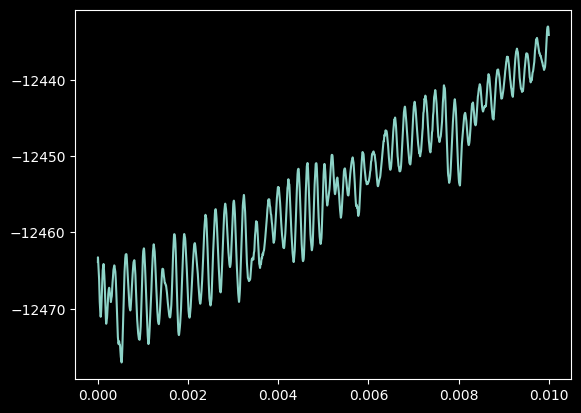

In [226]:
fns = "data_"+problem_name+"/"+method+"_[0-9][0-9][0-9][0-9][0-9].txt"
fns = glob.glob(fns)
fns.sort()

H_ex=np.zeros(len(fns))
for i in range(len(fns)):
    sx,sy,sz = np.transpose(np.loadtxt(fns[i]))
    H_ex[i] = np.dot(sx,np.dot(H_E,sx)) + np.dot(sy,np.dot(H_E,sy)) +np.dot(sz,np.dot(H_E,sz))
plt.plot(np.linspace(0,tmax,len(fns)),H_ex)

<Figure size 640x480 with 0 Axes>

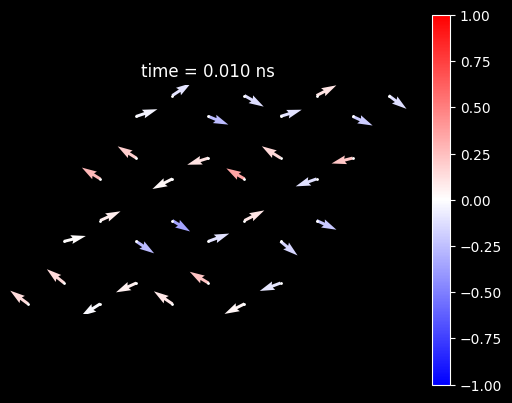

In [227]:
plt.style.use("dark_background")
plt.set_cmap('bwr')

fig, ax =plt.subplots()
#fig.set_size_inches(20, 20, forward=True)
#fig.set_dpi(72)
line = ax.plot([],[])

cmap = plt.get_cmap("bwr")
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm,ax=ax)

def init():
    fn_structure = "data_"+problem_name+"/structure.txt"
    site,a,b,x,y = np.transpose(np.loadtxt(fn_structure))
    ax.plot(x,y,'w.',markersize=2)

    return line

def updateLattice(frame):
    fn_structure = "data_"+problem_name+"/structure.txt"
    fn = fns[frame]
    sx,sy,sz = np.transpose(np.loadtxt(fn))
    site,a,b,x,y = np.transpose(np.loadtxt(fn_structure))

    arrowscale=0.3
    ax.clear()
    ax.plot(x,y,'w.',markersize=2)
    ax.quiver(x,y,sx*arrowscale,sy*arrowscale,sz,norm=norm)
    ax.set_aspect('equal')
    ax.axis("off")
    plt.title(f"time = {(frame*dt):0.3f} ns")

    return line


fns = "data_"+problem_name+"/"+method+"_[0-9][0-9][0-9][0-9][0-9].txt"
fns = glob.glob(fns)
fns.sort()
ani = animation.FuncAnimation(fig, updateLattice, frames=len(fns),init_func=init, blit=True)
ani.save('movie_'+problem_name+'.mp4',fps=10)